In [1]:
import numpy as np
import matplotlib.pyplot as plt
from few.waveform import GenerateEMRIWaveform, FastSchwarzschildEccentricFlux, FastKerrEccentricEquatorialFlux
from few.utils.constants import Gpc, MRSUN_SI, YRSID_SI
from typing import Optional, Union, Callable
from tqdm import tqdm

#try:
#    import cupy as cp
#    use_gpu = True
#except ImportError():
#    print("Not on GPU")
#    use_gpu = False

use_gpu = False

from stableemrifisher.fisher.fisher import StableEMRIFisher
from stableemrifisher.utils import inner_product

from fastlisaresponse import ResponseWrapper  # Response function 
from lisatools.detector import EqualArmlengthOrbits
from lisatools.sensitivity import get_sensitivity, A1TDISens, E1TDISens, T1TDISens

if not use_gpu:
    
    import few
    
    #tune few configuration
    cfg_set = few.get_config_setter(reset=True)
    
    cfg_set.enable_backends("cpu")
    cfg_set.set_log_level("info");
    force_backend = 'cpu'
else:
    force_backend = 'gpu'
    pass #let the backend decide for itself.

startup


/home/shubham/miniconda3/envs/SKeqfull/lib/python3.12/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [2]:
#waveform class setup
waveform_class = FastSchwarzschildEccentricFlux
waveform_class_kwargs = dict(inspiral_kwargs=dict(err=1e-11,),
                             mode_selector_kwargs=dict(mode_selection_threshold=1e-5))

#waveform generator setup
waveform_generator = GenerateEMRIWaveform
waveform_generator_kwargs = dict(return_list=False)

#ResponseWrapper setup
ResponseWrapper = ResponseWrapper
tdi_gen ="1st generation"# "2nd generation"#
order = 20  # interpolation order (should not change the result too much)
tdi_kwargs_esa = dict(
    orbits=EqualArmlengthOrbits(use_gpu=use_gpu), order=order, tdi=tdi_gen, tdi_chan="AE",
)  # could do "AET"
index_lambda = 8
index_beta = 7
# with longer signals we care less about this
t0 = 10000.0  # throw away on both ends when our orbital information is weird
T = 0.1
dt = 10.0

ResponseWrapper_kwargs = dict(
    #waveform_gen=waveform_generator,
    Tobs = T,
    dt = dt,
    index_lambda = index_lambda,
    index_beta = index_beta,
    t0 = t0,
    flip_hx = True,
    use_gpu=use_gpu,
    is_ecliptic_latitude=False,
    remove_garbage="zero",
    **tdi_kwargs_esa
)

#noise setup
channels = [A1TDISens, E1TDISens]
noise_model = get_sensitivity
noise_kwargs = [{"sens_fn": channel_i} for channel_i in channels]

In [3]:
sef = StableEMRIFisher(waveform_class=waveform_class, 
                       waveform_class_kwargs=waveform_class_kwargs,
                       waveform_generator=waveform_generator,
                       waveform_generator_kwargs=waveform_generator_kwargs,
                       ResponseWrapper=ResponseWrapper, ResponseWrapper_kwargs=ResponseWrapper_kwargs,
                       noise_model=noise_model, noise_kwargs=noise_kwargs, channels=channels,
                      stats_for_nerds = True, use_gpu = use_gpu,
                       T=T, dt=dt,
                      deriv_type='stable')

Body is not plunging, Fisher should be stable.
wave ndim: 2
Computing SNR for parameters: (1000000.0, 10.0, 0.0, 9.5, 0.4, 1.0, 0.1, 1.0471975511965976, 0.7853981633974483, 0.5235987755982988, 0.39269908169872414, 1.0, 0.0, 0.0)
Waveform Generated. SNR: 155.5201900922132
calculating stable deltas...
Gamma_ii for e0: 44657376369227.2
Gamma_ii for e0: 44657133104297.69
Gamma_ii for e0: 44657142493970.43
Gamma_ii for e0: 44657148515110.6
Gamma_ii for e0: 44657188199125.04
Gamma_ii for e0: 44657154977892.71
Gamma_ii for e0: 44656286336376.31
Gamma_ii for e0: 44653055442361.2
[np.float64(5.4473924456250825e-06), np.float64(2.1026138749149222e-07), np.float64(1.3483037704115012e-07), np.float64(8.886366571166592e-07), np.float64(7.439173486213127e-07), np.float64(1.945171861930793e-05), np.float64(7.235549691061699e-05)]
2


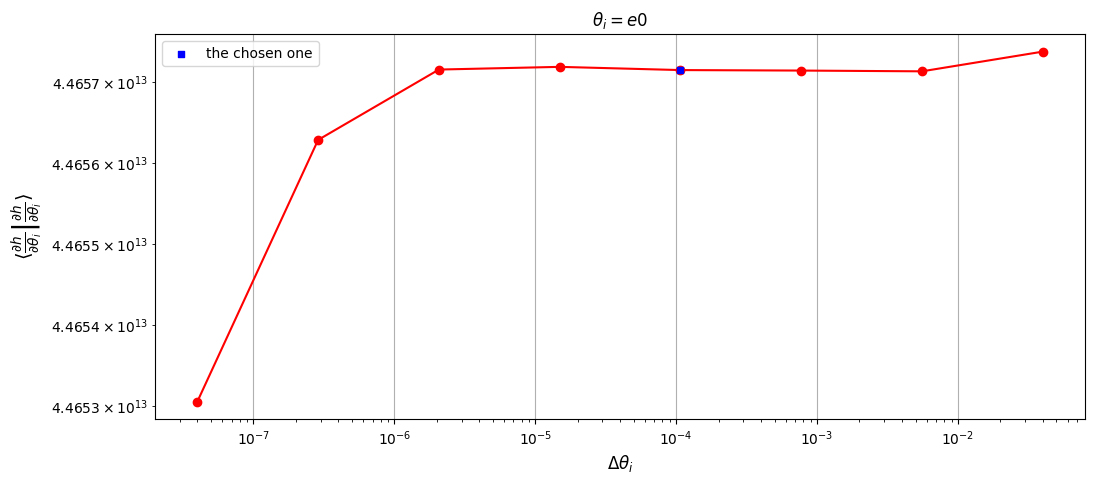

stable deltas: {'e0': 0.00010730783181118912}
Time taken to compute stable deltas is 44.398409843444824 seconds
calculating Fisher matrix...
Finished derivatives
Calculated Fisher is *atleast* positive-definite.
Time taken to compute FM is 5.937750339508057 seconds


In [6]:
m1 = 1e6
m2 = 1e1
a = 0.
p0 = 9.5
e0 = 0.4
xI0 = 1.0
dist = 0.1
qS = np.pi/3
phiS = np.pi/4
qK = np.pi/6
phiK = np.pi/8
Phi_phi0 = 1.0
Phi_theta0 = 0.0
Phi_r0 = 0.0

pars_list = [m1, m2, a, p0, e0, xI0, dist, qS, phiS, qK, phiK, Phi_phi0, Phi_theta0, Phi_r0]
wave_params = dict(
    m1=m1,
    m2=m2,
    a=a,
    p0=p0,
    e0=e0,
    xI0=xI0,
    dist=dist,
    qS=qS,
    phiS=phiS,
    qK=qK,
    phiK=phiK,
    Phi_phi0=Phi_phi0,
    Phi_theta0=Phi_theta0,
    Phi_r0=Phi_r0
)
param_names = ['e0']

der_order = 4
Ndelta = 8
stability_plot = True

delta_range = dict(
    m1 = np.geomspace(1e-4*m1, 1e-9*m1, Ndelta),
    m2 = np.geomspace(1e-2*m2, 1e-7*m2, Ndelta),
    p0 = np.geomspace(1e-2*p0, 1e-7*p0, Ndelta),
    e0 = np.geomspace(1e-1*e0, 1e-7*e0, Ndelta),
    qS = np.geomspace(1e-4,    1e-9,    Ndelta),
    phiS = np.geomspace(1e-4,    1e-9,    Ndelta),
    qK = np.geomspace(1e-4,    1e-9,    Ndelta),
    phiK = np.geomspace(1e-4,    1e-9,    Ndelta),
)

Fisher = sef(wave_params=wave_params, param_names = param_names, 
             der_order = der_order, 
             Ndelta = Ndelta, 
             stability_plot = stability_plot,
             delta_range = delta_range,
            live_dangerously = False)

In [8]:
if sef.deriv_type == 'stable': 
    if not sef.has_ResponseWrapper:
        Npad = sef.derivative.cache['Npad'] if sef.derivative.cache['Npad'] > 0 else 1
    else:
        try:
            Npad = sef.derivative.waveform_gen.cache['Npad'] if sef.derivative.waveform_gen.cache['Npad'] > 0 else 1
        except TypeError: #cache might be nonetype if direct derivatives are calculated, e.g. for the angles
            Npad = 1
else:
    Npad = 1

print(Npad)

1


In [9]:
#initialize response wrapper

wave_gen_base = waveform_generator(waveform_class=waveform_class,
                                   **sef.waveform_generator_kwargs)

wave_gen_resp = ResponseWrapper(
    waveform_gen = wave_gen_base,
    **ResponseWrapper_kwargs
)

In [10]:
if use_gpu:
    import cupy as cp
    xp = cp
else:
    xp = np
    
wave = xp.asarray([xp.concatenate((sef.waveform[i][:-Npad], xp.zeros(Npad)), dtype = sef.waveform.dtype) for i in range(len(sef.waveform))])

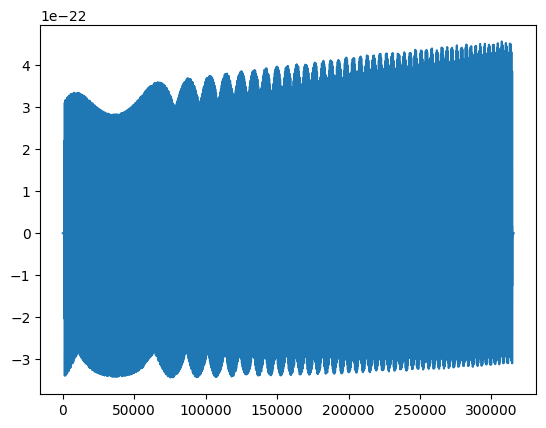

In [11]:
if use_gpu:
    wave = wave.get()

plt.plot(wave[0])

In [12]:
def Fisher_1D(partialh):
    return inner_product(partialh, partialh, PSD = PSD, dt = dt, use_gpu=use_gpu)

sigma1D = 1/np.sqrt(Fisher[0,0])
print(f"sigma", sigma1D)
PSD = sef.PSD_funcs

def likelihood(h_inj, h_temp):
    if len(h_inj) == 1:
        delta = h_inj - h_temp
        delta = [delta.real, -delta.imag]
    else:
        delta = [h_inj[i] - h_temp[i] for i in range(len(h_inj))]
        
    return np.exp(-0.5 * inner_product(delta, delta, PSD = PSD, dt = dt, use_gpu=use_gpu))

N = 50

param_to_vary_range = np.linspace(sef.wave_params[param_names[0]] - 4 * sigma1D, sef.wave_params[param_names[0]] + 4 * sigma1D, N)

likes = []

for i in tqdm(range(N)):
    parameters_in = sef.wave_params.copy()
    parameters_in[param_names[0]] = param_to_vary_range[i]
    parameters_in_list = list(parameters_in.values())
    htemp = xp.asarray(wave_gen_resp(
        *parameters_in_list,
        dt=dt, 
        T=T,
    ))

    htemp = xp.asarray([xp.concatenate((htemp[nchan][:-Npad], xp.zeros(Npad)), dtype = htemp.dtype) for nchan in range(len(channels))])

    #plt.plot(htemp.get()[0])
    #plt.plot(wave.get()[0], '--')
    #plt.show()
    
    likes.append(likelihood(wave, htemp))

sigma 1.496423451296482e-07


100%|███████████████████████████████████████████| 50/50 [02:43<00:00,  3.27s/it]


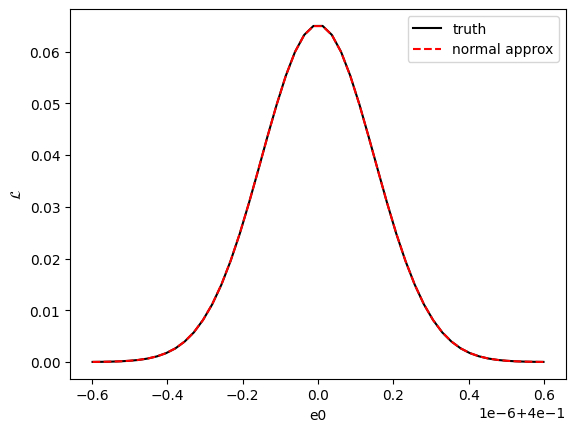

In [13]:
from scipy.stats import norm

normal_approx = norm.pdf(param_to_vary_range, loc = sef.wave_params[param_names[0]], scale = sigma1D)
normal_approx /= np.sum(normal_approx)
plt.plot(param_to_vary_range, likes/np.sum(likes), c='k', label='truth')
plt.plot(param_to_vary_range, normal_approx, c='r', label='normal approx', linestyle='--')
plt.legend()
plt.ylabel(r'$\mathcal{L}$')
plt.xlabel(param_names[0])
#plt.savefig(f'1D_like_vs_NA_{param_names[0]}.png', dpi = 300, bbox_inches='tight')
plt.show()